Got the right star this time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)


massA = 0.846
teffA = 5407
teff_eA = 52
radiusA = 0.8310

massB = 0.698
teffB = 4393
teff_eB = 149
radiusB = 0.6697

distance = 5.113

save_path = 'models/'
# star = 'toi-134'
gA = ((G*massA*M)/(radiusA*R)**2).to(u.cm/u.s**2)
gB = ((G*massB*M)/(radiusB*R)**2).to(u.cm/u.s**2)
# print(gA, gB)
# g = 4.04
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

A_star_params = {'Teff': teffA, 'Teff_e':teff_eA,  'logg': np.log10(gA.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusA*u.R_sun, 'Distance':distance*u.pc}
# pwA, pfA, peA = pp.make_phoenix_spectrum('70_oph_A', save_path, repo, A_star_params, save_ecsv=True, plot=True, make_error=True)
pdataA = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_A'))
pwA, pfA, peA = pdataA['WAVELENGTH'], pdataA['FLUX'], pdataA['ERROR']
normfacA = ((radiusA*R)/((distance*u.pc).to(u.m)))**2

B_star_params = {'Teff': teffB, 'Teff_e':teff_eB,  'logg': np.log10(gB.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusB*u.R_sun, 'Distance':distance*u.pc}
# pwB, pfB, peB = pp.make_phoenix_spectrum('70_oph_B', save_path, repo, B_star_params, save_ecsv=True, plot=True, make_error=True)
pdataB = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_B'))
pwB, pfB, peB = pdataB['WAVELENGTH'], pdataB['FLUX'], pdataB['ERROR']
normfacB = ((radiusB*R)/((distance*u.pc).to(u.m)))**2

pw, pf, pe= pwB, pfB, peB
normfac = normfacB

Only COS FUV data. Have a look, then make a clean spectrum for ETC for a STIS proposal.

In [3]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/complete_spectra/cos/complete_spectra/'

In [4]:
cspecs = glob.glob('{}*cspec.fits'.format(path))
cspecs

[]

In [5]:
for x in cspecs:
    print(x)
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    # mask = w > 1160
    # w, f, e = w[mask], f[mask], e[mask]
    fig, ax = plt.subplots()
    ax.step(w, f, where='mid', c='C0')
    ax.step(w, e, where='mid', c='C1', alpha=0.5)



all pretty good, use one for an etc input

In [6]:
# etc = Table([w, f], names=['#WAVELENGTH', 'FLUX'])
# etc.write('etc_input/70oph_B_cos.dat', format='ascii.basic', overwrite=True)

We used the spectrum from PID 16003 for the DEM, have to reproduce that

In [9]:
cospath = '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/'
x1ds = glob.glob('{}*x1dsum.fits'.format(cospath))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']

G130M le5s11vzq
G160M le5s11w7q


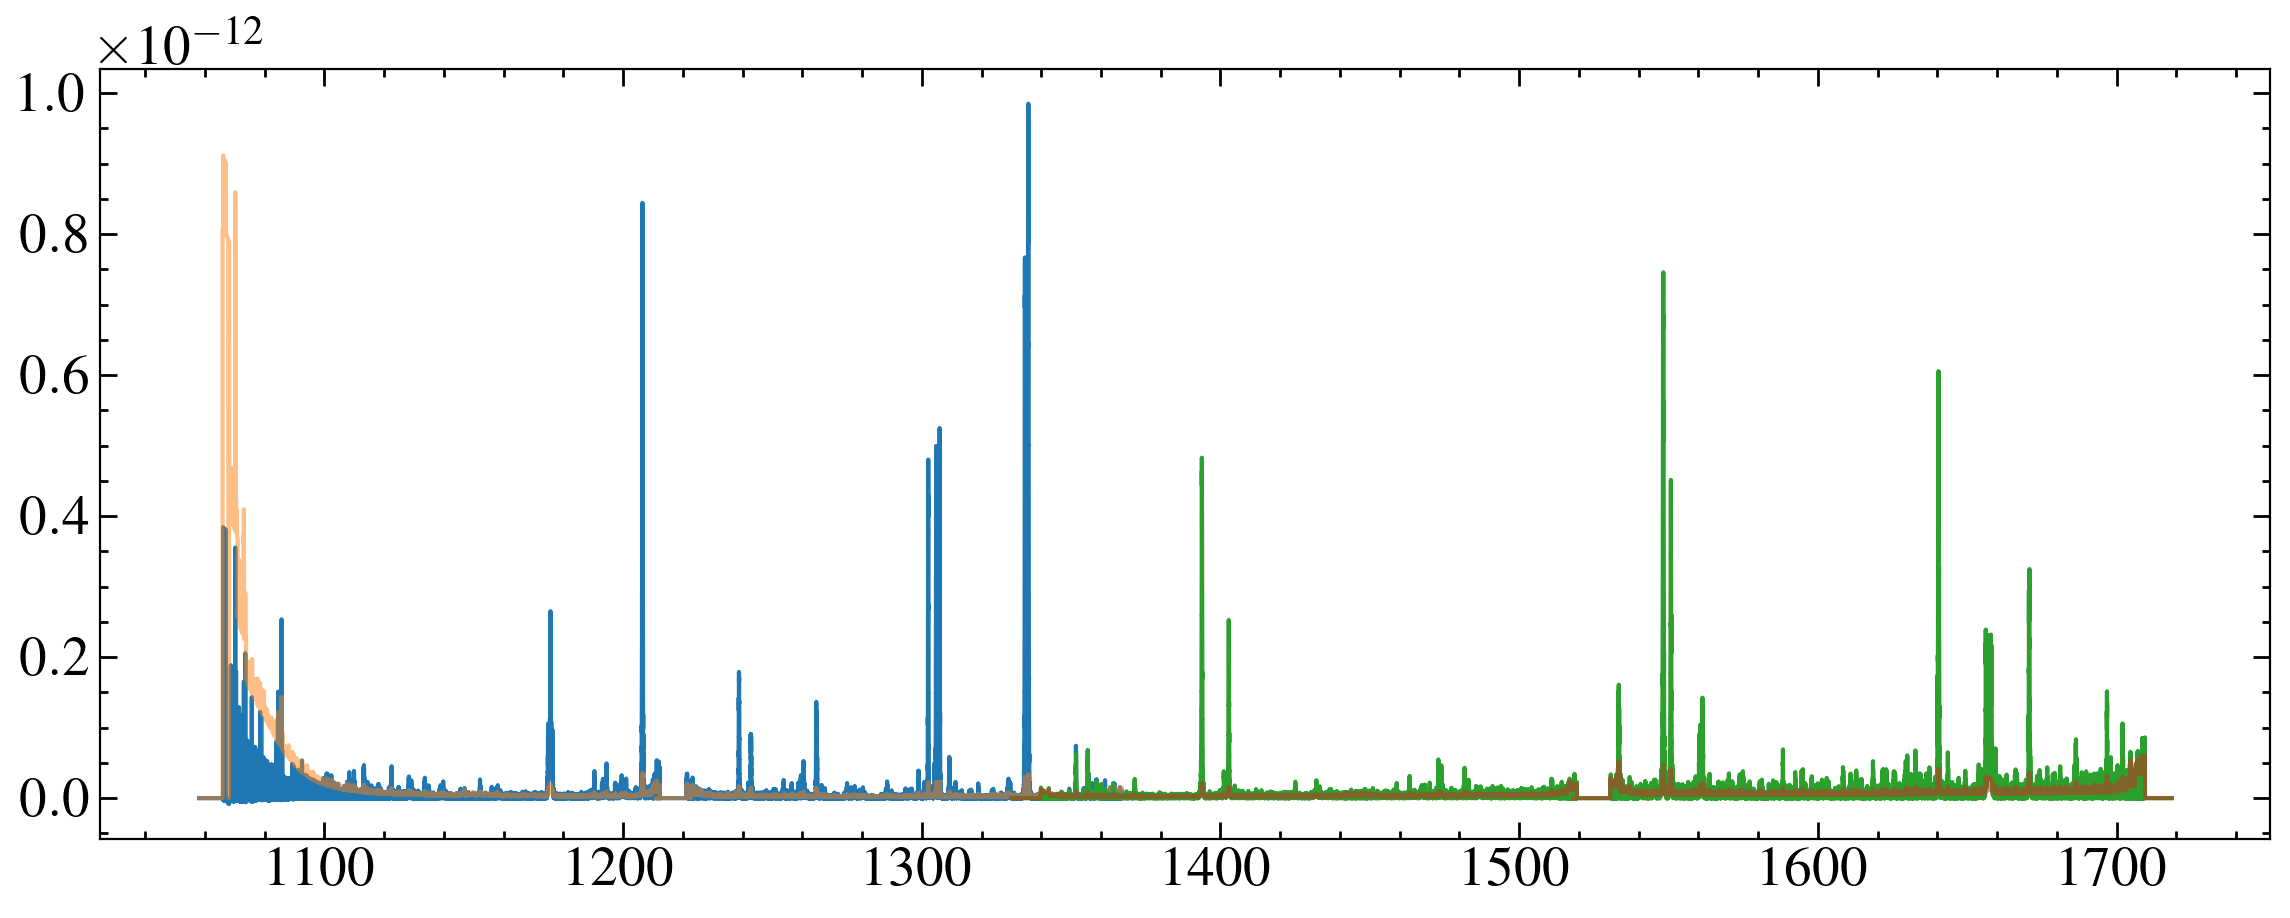

In [38]:
fig, ax = plt.subplots()
for x in x1ds:
    data = fits.getdata(x, 1)[::-1]
    hdr = fits.getheader(x, 0)
    grating = hdr['OPT_ELEM']
    rootname= hdr['ROOTNAME']
    print(grating, rootname)
    w, f, e = np.hstack(data['WAVELENGTH']), np.hstack(data['FLUX']), np.hstack(data['ERROR'])
    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid', alpha=0.5)
    args = np.argsort(w)
    w, f ,e = w[args], f[args], e[args]
    savdat = Table([w, f, e], names = ['WAVELENGTH', 'FLUX', 'ERROR'])
    savdat.write('cos_files/70_oph_b/{}_{}_simple.txt'.format(rootname, grating), format='ascii.basic', overwrite=True)
    # ax.plot(w[:-1], np.diff(w))

['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']


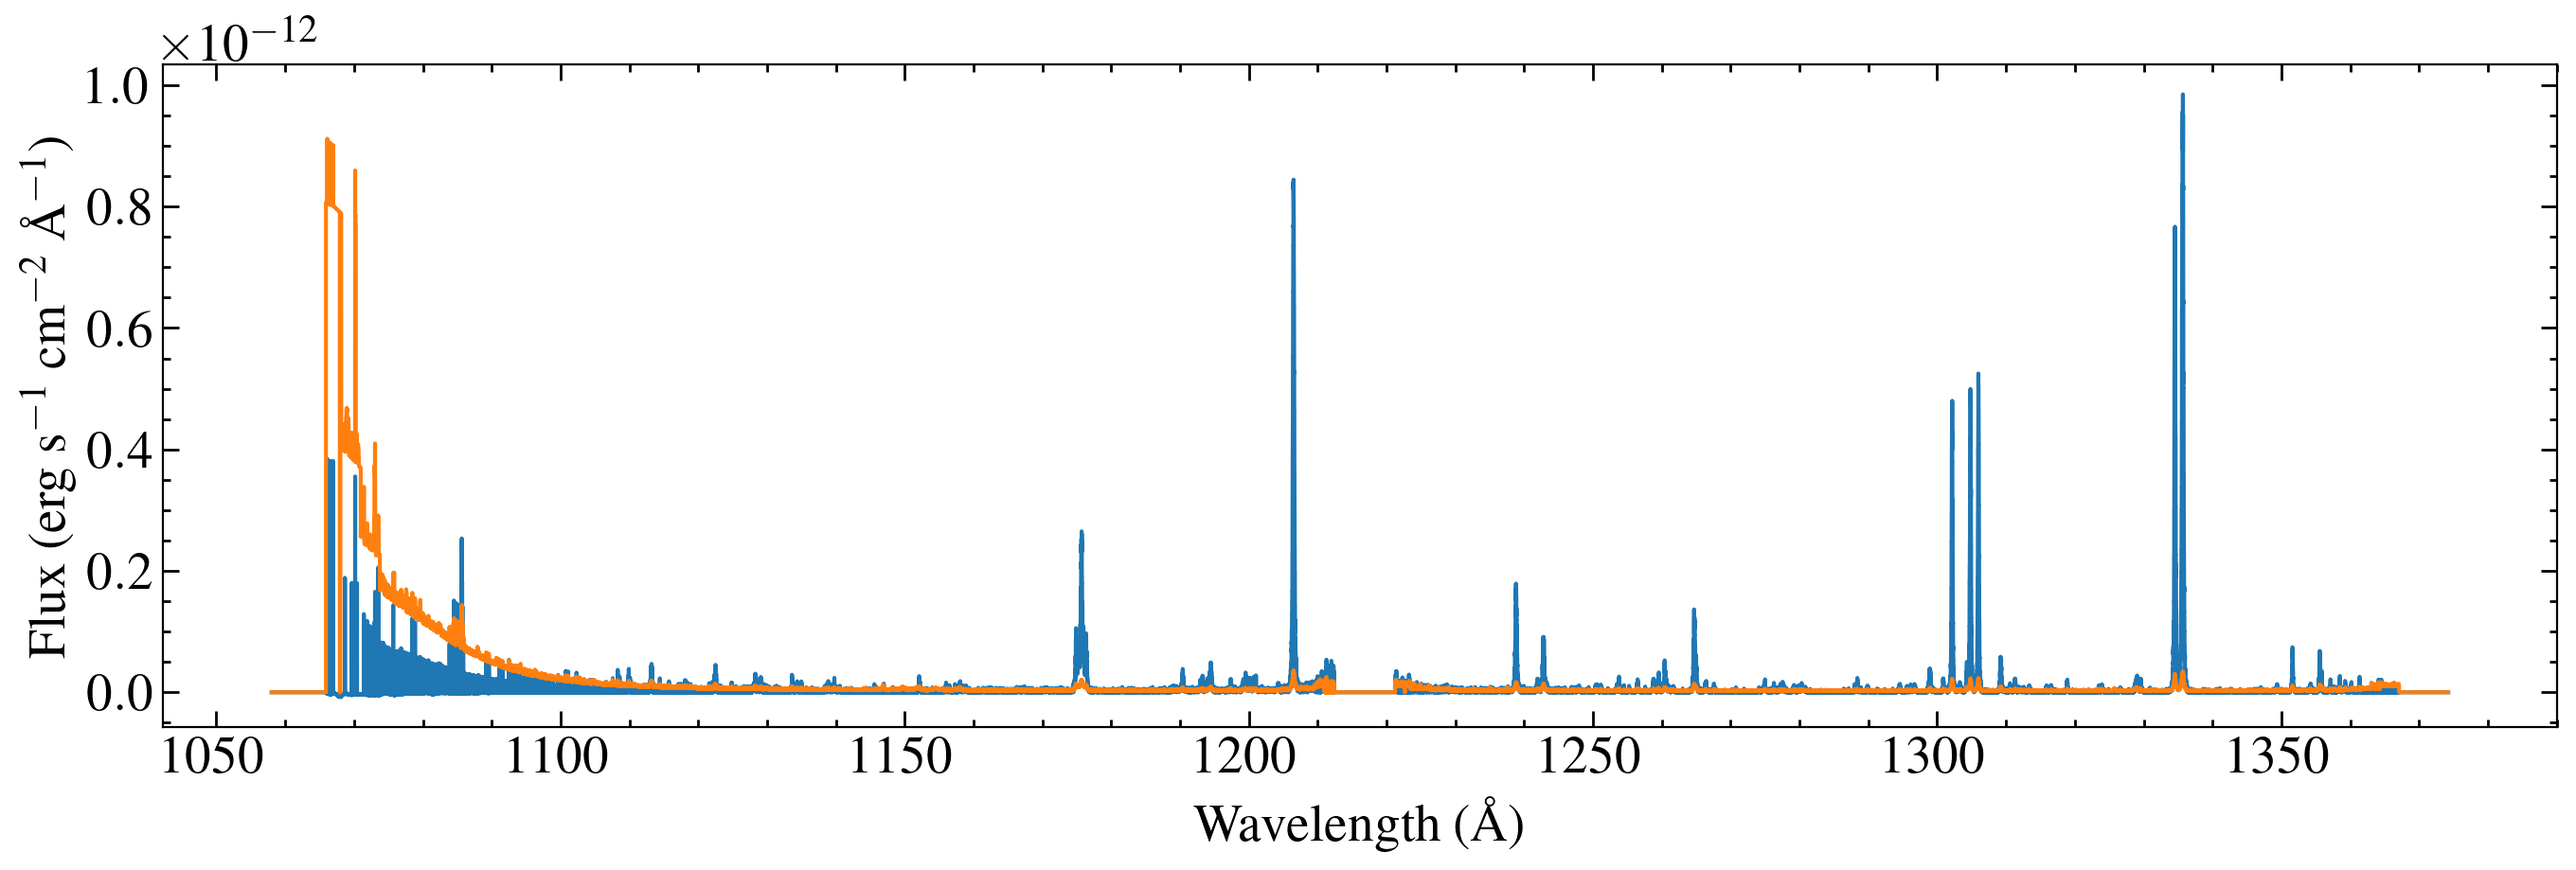

Spectrum saved as hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']
['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/cos/use_spectra/le5s11020_x1dsum.fits']


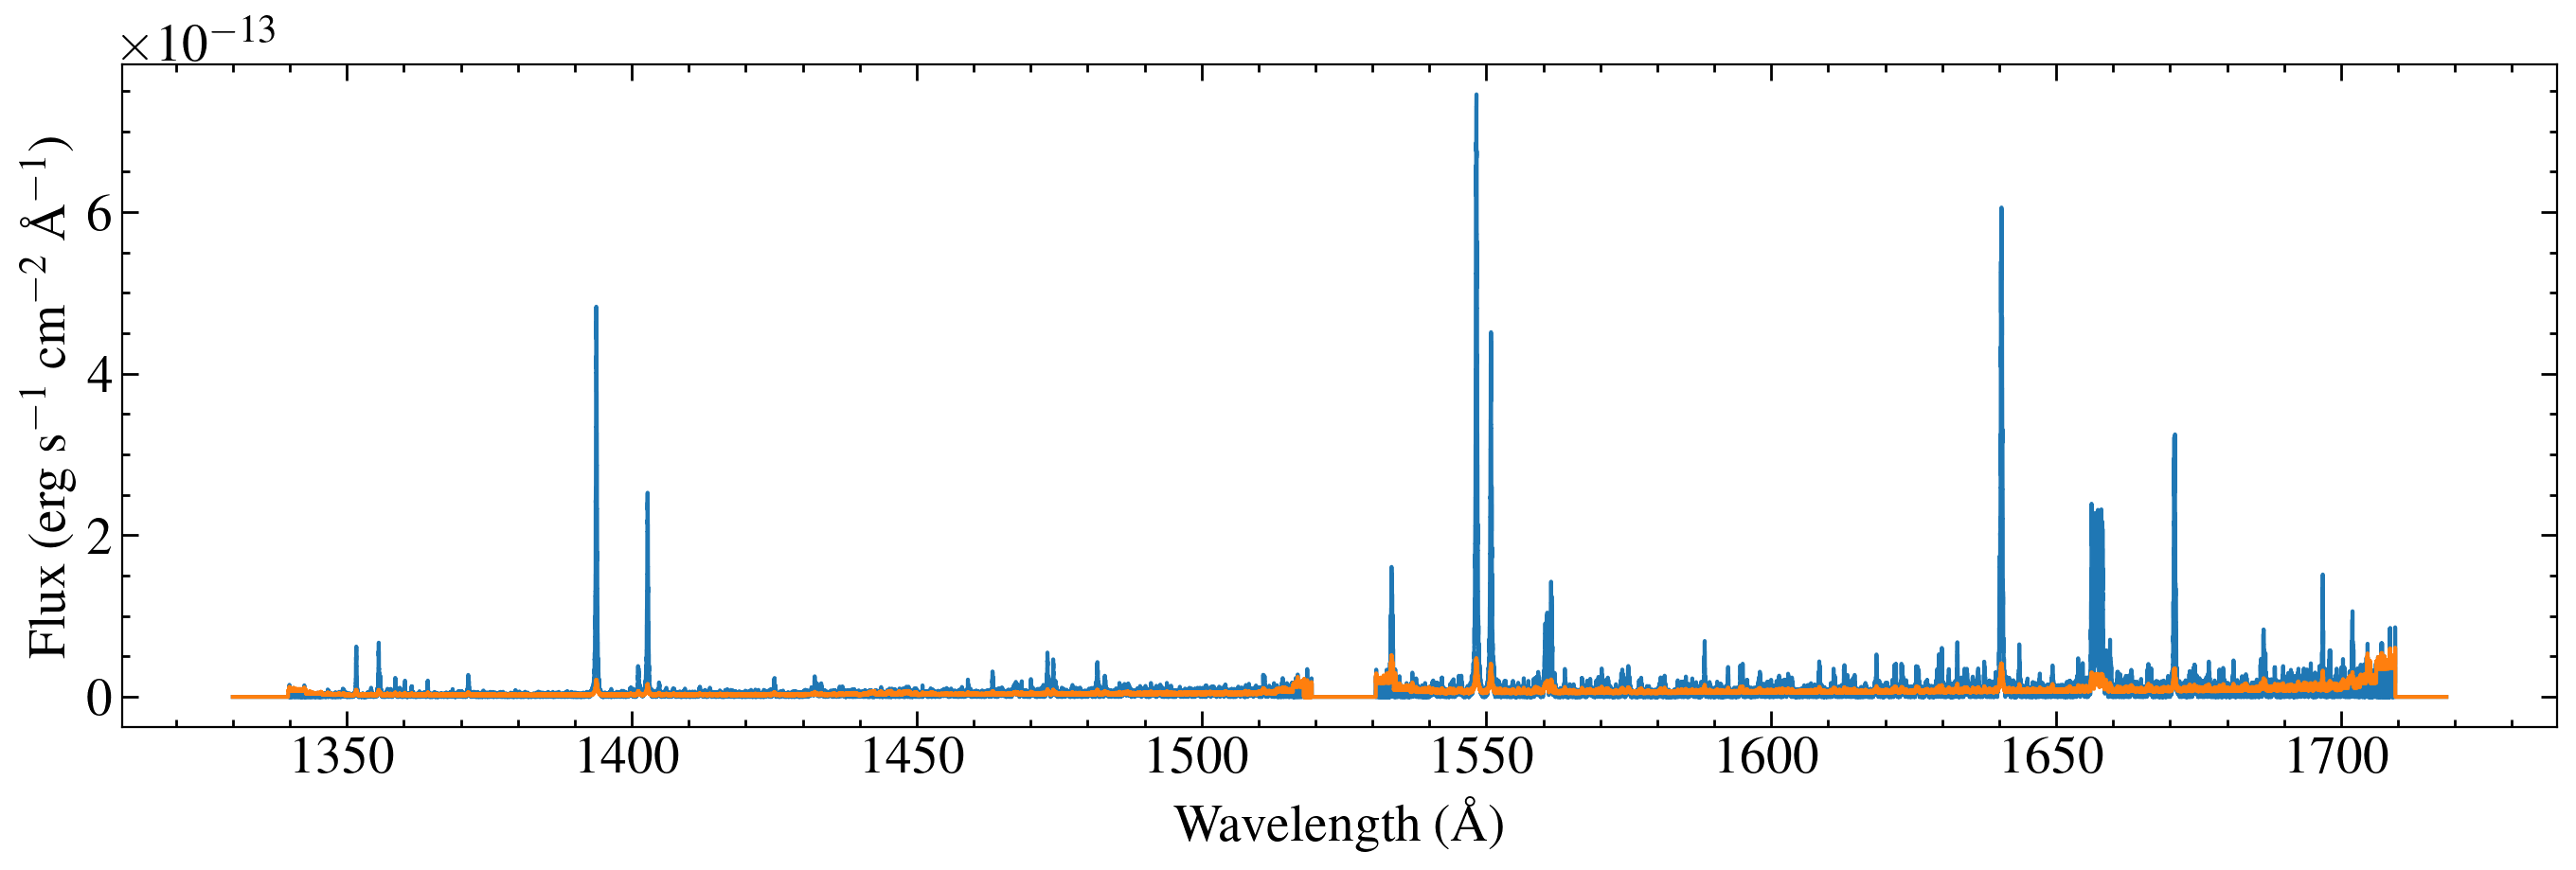

Spectrum saved as hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits


In [45]:
import importlib
import prepare_cos
importlib.reload(prepare_cos)

savpath = glob.glob('cos_files/70_oph_b/*')
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/70_Oph_B/'
# star = 
for sav in savpath:
    # print(sav)

    prepare_cos.make_cos_spectrum(sav, version, cospath, hlsp, savepath = savepath, plot=True, save_fits=True, star='70_Oph_B')

I think there's a bug in prepare COS when it comes to chooseing the x1d files. Not worth fixing, do in the great hasp upgrade.

In [ ]:
import prepare_model
hdr = fits.getheader('draft_hlsp/70_Oph_B/hlsp_muscles_hst_cos_70_oph_b_g160m_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
#PHX
prepare_model.make_model_spectrum('models/eps_indi_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')
